<a href="https://colab.research.google.com/github/swoo-nam/project_final_team1/blob/main/%EC%84%9C%EB%B9%84%EC%8A%A4_1_%2B_%EC%A0%95%EB%B3%B4%EC%A0%9C%EA%B3%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import re
import torch
from tqdm.auto import tqdm
import random
import os

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# DATA_PATH = "/content/drive/MyDrive/생성 AI 모델링/data/"
DATA_PATH = "/content/drive/MyDrive/멀티캠퍼스 자료/Machine Learning/data/"
SEED = 42

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


'cpu'

In [3]:
store_list = pd.read_excel(f"{DATA_PATH}요기요가게취합(0908업데이트).xlsx")


In [4]:
ygy_clean_0905 = pd.read_csv(f"{DATA_PATH}yogiyo_reviews_0905_clean.csv")


yogiyo =pd.read_csv(f"{DATA_PATH}yogiyo_reviews_0908.csv") #37000개


sentiment_train = pd.read_csv(f"{DATA_PATH}posneg_train_37000.csv")

neg_train = pd.read_csv(f"{DATA_PATH}gpt_neg_9300.csv")


train= yogiyo[['고객리뷰','사장댓글','별점']]

# train = yogiyo[['review', 'reply','rating']]

rename_cols = ['review', 'reply','rating']
train.columns = rename_cols
train.head()


tmp = sentiment_train[['sentiment','score']]
train = pd.concat([train,tmp],axis=1)

train

,review,reply,rating,sentiment,score
0,맛있게 잘먹었습니다 묵사발도 시원하니 맛있네요,즐거운 순간을 저희와 함께해주셔서 감사합니다💖 \n\n보람차게 일할 수 있게 해 주...,5,1,0.566494
1,기름 있는 부분이 생각보다 많아요! 참고하세요:),소중한 의견 남겨 주셔서 감사합니다. 잘 새겨 듣고 앞으로 더욱 더 개선 할 수 있...,5,0,0.723872
2,양도 푸짐하고 맛있습니다! 청국장 냄새 많이 안나고 콩도 많이 들어있어서 좋았습니다!,늘 최고의 메뉴를 제공해드리고 싶습니다!😄 \n\n맛있는 메뉴를 넉넉하게 먹을 수 ...,5,1,0.608408
3,"..,........",저희 매장과 함께 편안한 시간 되셨을까요? \n\n1. 고객을 생각하는 마음 \n2...,5,0,0.499478
4,냉면을 따로 시키고 미니냉면을 합친것인데 양이 좀 적어보이고. 김치정식도 양이 적어...,이번 주문을 통해 한걸음 더 가까워진 것 같아 기분이 좋아요!😁\n\n고객님의 행복...,5,1,0.381793
...,...,...,...,...,...
37135,맛있어요 ㅎ저번에주문하고 맛있어서또주문핰건데\n늦은시간에시켜서그렄지 국물이 엄청 걸...,고객님 안녕하세요 짬뽕관입니다~~^-^\n소중한 리뷰 너무 감사합니다!!🙂\n재주문...,5,1,0.424215
37136,맛있어요 또시킬게요,고객님 안녕하요 짬뽕관입니다!!^_^\n소중한 리뷰 남겨주셔 서 정말 달감사합니다!...,5,1,0.720691
37137,정말 맛있게 잘먹었어요!!자주 시켜 먹을께요!,고객님 안녕하세요 짬뽕관입니다~~^_^\n맛있게 드셨다는 말씀에 힘이 나는거 같습니...,5,1,0.833007
37138,와우.. 여기뭐죠 주변에서 맛있다고 먹어보라해서 시켰는데 육수가 일단 시원칼칼하니 ...,고객님 안녕하세요 짬뽕관입니다!!^_^\n맛있게 드셔주시고 정성스러운 사진 리뷰까지...,5,1,0.900031


In [5]:
train = train[['review','reply','sentiment','score']]

In [6]:
neg_train

,original_review,original_reply,rating,gpt_review,gpt_reply,sentiment,score
0,맛도 양도 모두 만족합니다 배달도 정확히 보내 주시고 아주 만족합니다.,"안녕하세요! 주문해 주셔서 진심으로 감사드려요! 이렇게 좋은 리뷰 써 주시니, 메뉴...",5,김치찌개는 별로였어요. 약간 김치국 느낌이 나서 실망했어요. 고기도 별로였고.,안녕하세요. 김치찌개와 고기에 대한 실망을 드려 죄송합니다. 지속적인 품질 개선을 ...,0,0.908812
1,너무 맛있게 잘 먹었습니다!,즐거운 순간을 저희와 함께해주셔서 감사합니다 보람차게 일할 수 있게 해 주셔서 감사...,5,양이 너무 많아서 배터질뻔했어요. 서비스도 별로였어요.,배터질뻔하셨다니 정말 안타깝습니다. 양에 대한 조정을 더 신경써야겠습니다. 불편을 ...,0,0.820514
2,너무 배고파서 먹다가 찍었어요. 너무맛있어요,행복한 하루를 만들어 주셔서 감사합니다 직접 드시는 건데 맛은 당연히 좋아야 된다고...,5,음식이 너무 싱겁고 부족해서 맛이 없었어요. 배달도 늦게 왔고 실망스러웠어요.,음식 맛과 배달 시간에 대한 실망을 드려 죄송합니다. 앞으로 더 신속하고 맛있는 음...,0,0.941290
3,두번째시켜요~ 이번엔 아이들이 잡채가 먹고싶대서 주문해봤는데 고기도 많이 들어가있고...,다시 주문해 주셔서 감사합니다 저희 메뉴 맛있죠? 이제 점점 저희 메뉴만 생각 나실...,5,잡채는 짜다고 하지도 않았는데 맛이 진짜 짜요. 먹기 어려웠어요.,잡채가 짜다는 피드백을 반영하지 못해 죄송합니다. 더 맛있고 조리하기 쉽도록 개선하...,0,0.910234
4,푸짐하고 너무 맛있어용~,이렇게 저희를 선택해 주셔서 감사합니다~ ~ 맛있게 먹다가 양이 부족하다.? 저는 ...,5,가격에 비해 음식의 양도 적고 맛도 별로였어요. 실망이었습니다.,가격과 맛에 대한 실망을 드려 죄송합니다. 더 다양한 메뉴와 향상된 품질로 보답하겠...,0,0.928585
...,...,...,...,...,...,...,...
9318,늘믿고먹어요 싱싱맛나요,안녕하세요~ 상무초밥 유성점입니다~! 저희 매장을 이용해주셔서 정말 감사드립니다! ...,5,"맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬...","안녕하세요, 고객님. 말씀해주신 점 먼저 진심으로 사과드립니다. 맛과 촉감에 실망하...",0,0.942769
9319,초밥은 늘 여기만 주문해요. 늘 맛나요,안녕하세요~ 상무초밥 유성점입니다~! 저희 매장을 이용해주셔서 정말 감사드립니다! ...,5,"맛도 없고, 배달도 늦어서 너무 실망했습니다",고객님께 실망을 드려 죄송합니다. 저희 음식이 맛있지 않아서 큰 실망을 받으셨군요....,0,0.912723
9320,해장하려구 시켰는데 진짜 맛있네용 . 다음에 또 시켜먹을게요 감사합니다 !,안 녕 하세요 해장은 잘 하셨어요? 속풀이에도 좋고 한잔 할때도 좋고 다 어울리지요...,5,진짜 최악이었어요. 맛도 없고 배달도 오래걸렸어요,맛이 없고 배달이 늦어서 정말 죄송합니다. 저희는 항상 맛과 배달 시간을 최우선으로...,0,0.894588
9321,늘 맛있어요~ 사진이 없어요~ 또 시킬께요~예쁜사진과 함께,감사합니다 다음에는 예쁜 사진 기대할게요. 오늘도 좋은 하루 되세요. 또 맛있게 뵙...,5,완전 별로였어요. 음식이 시큼해서 입에 맞지가 않았어요,고객님께 실망을 드려 정말 죄송합니다. 음식에 대한 맛과 냄새에 대한 불만을 제기해...,0,0.933854


In [7]:
neg_train = neg_train[['gpt_review','gpt_reply','sentiment','score']]
neg_train.columns = train.columns

In [8]:
train_ft = pd.concat([train,neg_train], axis=0)
train_ft #총 46463개

,review,reply,sentiment,score
0,맛있게 잘먹었습니다 묵사발도 시원하니 맛있네요,즐거운 순간을 저희와 함께해주셔서 감사합니다💖 \n\n보람차게 일할 수 있게 해 주...,1,0.566494
1,기름 있는 부분이 생각보다 많아요! 참고하세요:),소중한 의견 남겨 주셔서 감사합니다. 잘 새겨 듣고 앞으로 더욱 더 개선 할 수 있...,0,0.723872
2,양도 푸짐하고 맛있습니다! 청국장 냄새 많이 안나고 콩도 많이 들어있어서 좋았습니다!,늘 최고의 메뉴를 제공해드리고 싶습니다!😄 \n\n맛있는 메뉴를 넉넉하게 먹을 수 ...,1,0.608408
3,"..,........",저희 매장과 함께 편안한 시간 되셨을까요? \n\n1. 고객을 생각하는 마음 \n2...,0,0.499478
4,냉면을 따로 시키고 미니냉면을 합친것인데 양이 좀 적어보이고. 김치정식도 양이 적어...,이번 주문을 통해 한걸음 더 가까워진 것 같아 기분이 좋아요!😁\n\n고객님의 행복...,1,0.381793
...,...,...,...,...
9318,"맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬...","안녕하세요, 고객님. 말씀해주신 점 먼저 진심으로 사과드립니다. 맛과 촉감에 실망하...",0,0.942769
9319,"맛도 없고, 배달도 늦어서 너무 실망했습니다",고객님께 실망을 드려 죄송합니다. 저희 음식이 맛있지 않아서 큰 실망을 받으셨군요....,0,0.912723
9320,진짜 최악이었어요. 맛도 없고 배달도 오래걸렸어요,맛이 없고 배달이 늦어서 정말 죄송합니다. 저희는 항상 맛과 배달 시간을 최우선으로...,0,0.894588
9321,완전 별로였어요. 음식이 시큼해서 입에 맞지가 않았어요,고객님께 실망을 드려 정말 죄송합니다. 음식에 대한 맛과 냄새에 대한 불만을 제기해...,0,0.933854


# 데이터 정제

- 정규표현식

In [9]:
review_list = []
for review in train_ft['review']:
    if isinstance(review, str):

        pat = re.compile("[^가-힣0-9.,~?!]") # 영어 제거
        result = pat.sub(" ", review)

        result = re.sub(r'^[.]\s*', '', result, count=1)
        result = re.sub(r'^[. ]+', '', result, count=1)

        result = re.sub(r',\s*$', '', result)
        result = re.sub(r'^\s*,', '', result)
        result = re.sub(r'\.{2,}', '.', result)
        result = re.sub(r'\,{2,}', ',', result)
        result = re.sub(r'\~{2,}', '~', result)
        result = re.sub(r'\!{2,}', '!', result)
        result = re.sub(r'\?{2,}', '?', result)
        result = re.sub(" +", " ", result)
        review_list.append(result)
    else:
        review_list.append("")

train_ft['review'] = review_list
train_ft.head()

,review,reply,sentiment,score
0,맛있게 잘먹었습니다 묵사발도 시원하니 맛있네요,즐거운 순간을 저희와 함께해주셔서 감사합니다💖 \n\n보람차게 일할 수 있게 해 주...,1,0.566494
1,기름 있는 부분이 생각보다 많아요! 참고하세요,소중한 의견 남겨 주셔서 감사합니다. 잘 새겨 듣고 앞으로 더욱 더 개선 할 수 있...,0,0.723872
2,양도 푸짐하고 맛있습니다! 청국장 냄새 많이 안나고 콩도 많이 들어있어서 좋았습니다!,늘 최고의 메뉴를 제공해드리고 싶습니다!😄 \n\n맛있는 메뉴를 넉넉하게 먹을 수 ...,1,0.608408
3,.,저희 매장과 함께 편안한 시간 되셨을까요? \n\n1. 고객을 생각하는 마음 \n2...,0,0.499478
4,냉면을 따로 시키고 미니냉면을 합친것인데 양이 좀 적어보이고. 김치정식도 양이 적어...,이번 주문을 통해 한걸음 더 가까워진 것 같아 기분이 좋아요!😁\n\n고객님의 행복...,1,0.381793


In [10]:
reply_list = []
for reply in train_ft['reply']:
    if isinstance(reply, str):

        pat = re.compile("[^가-힣0-9.,~?!]") # 영어 제거
        result = pat.sub(" ", reply)

        result = re.sub(r',\s*$', '', result)
        result = re.sub(r'^[.]\s*', '', result, count=1)
        result = re.sub(r'^[. ]+', '', result, count=1)

        result = re.sub(r'^\s*,', '', result)
        result = re.sub(r'\.{2,}', '.', result)
        result = re.sub(r'\,{2,}', ',', result)
        result = re.sub(r'\~{2,}', '~', result)
        result = re.sub(r'\!{2,}', '!', result)
        result = re.sub(r'\?{2,}', '?', result)
        result = re.sub(" +", " ", result)
        reply_list.append(result)
    else:
        reply_list.append("")

train_ft['reply'] = reply_list
train_ft.head()

,review,reply,sentiment,score
0,맛있게 잘먹었습니다 묵사발도 시원하니 맛있네요,즐거운 순간을 저희와 함께해주셔서 감사합니다 보람차게 일할 수 있게 해 주셔서 감사...,1,0.566494
1,기름 있는 부분이 생각보다 많아요! 참고하세요,소중한 의견 남겨 주셔서 감사합니다. 잘 새겨 듣고 앞으로 더욱 더 개선 할 수 있...,0,0.723872
2,양도 푸짐하고 맛있습니다! 청국장 냄새 많이 안나고 콩도 많이 들어있어서 좋았습니다!,늘 최고의 메뉴를 제공해드리고 싶습니다! 맛있는 메뉴를 넉넉하게 먹을 수 있는 것보...,1,0.608408
3,.,저희 매장과 함께 편안한 시간 되셨을까요? 1. 고객을 생각하는 마음 2. 더 나은...,0,0.499478
4,냉면을 따로 시키고 미니냉면을 합친것인데 양이 좀 적어보이고. 김치정식도 양이 적어...,이번 주문을 통해 한걸음 더 가까워진 것 같아 기분이 좋아요! 고객님의 행복한 시간...,1,0.381793


- 한글이 포함되지 않은 리뷰 제거

In [11]:
pattern = r'^[^가-힣]*$'
# 패턴을 포함하는 문자열을 찾아 mask 생성
mask = (train_ft['review'].str.match(pattern)) | (train_ft['reply'].str.match(pattern))

train_ft = train_ft[~mask]


- 고객 id처리

In [12]:
# 님 앞의 문자들 고객님으로 처리. 짧은 리뷰 제거 이전 처리함.
train_ft['reply'] = train_ft['reply'].str.replace(r'.*님', '고객님', regex=True)

# for review in train['reply']:
#   if '고객님' in review:
#       print(review)


<ipython-input-12-81e8c7485aa7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ft['reply'] = train_ft['reply'].str.replace(r'.*님', '고객님', regex=True)


- 짧은 리뷰 제거

In [13]:
mask = train_ft['reply'].str.len() <= 10
train_ft[mask]

train_ft = train_ft[~mask]
train_ft

,review,reply,sentiment,score
0,맛있게 잘먹었습니다 묵사발도 시원하니 맛있네요,즐거운 순간을 저희와 함께해주셔서 감사합니다 보람차게 일할 수 있게 해 주셔서 감사...,1,0.566494
1,기름 있는 부분이 생각보다 많아요! 참고하세요,소중한 의견 남겨 주셔서 감사합니다. 잘 새겨 듣고 앞으로 더욱 더 개선 할 수 있...,0,0.723872
2,양도 푸짐하고 맛있습니다! 청국장 냄새 많이 안나고 콩도 많이 들어있어서 좋았습니다!,고객님께서도 행복하시길 바랄게요,1,0.608408
4,냉면을 따로 시키고 미니냉면을 합친것인데 양이 좀 적어보이고. 김치정식도 양이 적어...,고객님의 행복한 시간에 저희 매장이 함께 할 수 있어 너무나도 영광입니다! 즐거움이...,1,0.381793
5,맛나게 잘 묵었습니다,"고객님의 즐거운 순간을 함께할 수 있기를 바라며, 기다리고 있겠습니다 더욱 발전된 ...",1,0.549870
...,...,...,...,...
9318,"맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬...",고객님. 말씀해주신 점 먼저 진심으로 사과드립니다. 맛과 촉감에 실망하셨다니 정말 ...,0,0.942769
9319,"맛도 없고, 배달도 늦어서 너무 실망했습니다",고객님께 실망을 드려 죄송합니다. 저희 음식이 맛있지 않아서 큰 실망을 받으셨군요....,0,0.912723
9320,진짜 최악이었어요. 맛도 없고 배달도 오래걸렸어요,맛이 없고 배달이 늦어서 정말 죄송합니다. 저희는 항상 맛과 배달 시간을 최우선으로...,0,0.894588
9321,완전 별로였어요. 음식이 시큼해서 입에 맞지가 않았어요,고객님들께 더 맛있는 음식을 제공하기 위해 항상 노력하고 있습니다. 맛과 냄새에 대...,0,0.933854


# 서비스 1 - 토픽 라벨 및 % 제공

## 학습데이터
- Rule Base 카테고리 분류
- 입력 -> 맞춤법 검사 -> rule base로 카테고리화 -> 가격 / 맛 / 양 각각에 대해서 몇% 이고, 각각에 대해 긍정인지 부정인지 확인.

In [14]:
!pip install kiwipiepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 53.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kiwipiepy-model: filename=kiwipiepy_model-0.16.0-py3-none-any.whl size=30813255 sha256=552ae7639236d760271064447a85c497270c94fdd94d35b30cfe74efae92d1eb
  Stored in directory: /root/.cache/pip/wheels/6b/03/2b/ac2c97cc65ebd9df3516f4b900adc2f0a744df8d1375b2e2ef
Successfully built kiwipiepy-model


In [15]:
!pip install keybert


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.4 MB/s eta 0:00:00
  Created wheel for keybert: filename=keybert-0.7.0-py3-none-any.whl size=23765 sha256=65d2d827c8db56ac9cfdefcfbd43a4f5f7e9bf99714a6a6c5ed9e43cc7bb8bb4
  Stored in directory: /root/.cache/pip/wheels/66/8d/e6/b0e2f8d883b0fd51819226f67ad9843e04913ce4a97241ff4b
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=f792dbb7acd9fe2e2c27e7496f1bc352a55c5cc149694cdb2e2deb14fe78bcdf


In [16]:
from kiwipiepy import Kiwi

kiwi = Kiwi()

In [17]:

kiwi_reviews = []

for review in tqdm(train_ft['review']):
    results = []  # 결과 리스트를 각 리뷰마다 초기화
    result = kiwi.analyze(review)
    for token, pos, _, _ in result[0][0]:
        if pos in ['NNG', 'VA', 'VV', 'XR']:  # 일반명사, 형용사, 동사, 어근
            results.append(token)
    kiwi_reviews.append(results)


  0%|          | 0/45124 [00:00<?, ?it/s]

In [18]:
train_ft['kiwi_reviews'] = kiwi_reviews


In [19]:
# 우선은 이전에 뽑아놨던 키워드 활용


# import re

# total_keybert = []

# for i in train_ft['keybert_reviews']:
#     korean_words = re.findall(r'[가-힣]+', i)  # ' ' 사이의 한글 단어 추출
#     total_keybert.extend(korean_words)



In [ ]:
# from collections import Counter

# word_counts = Counter(total_keybert)

# sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# for word, count in sorted_word_counts[:200]:
#     print(f"{word}: {count}")


In [20]:

#200위 내 키워드들 중에 맛, 양, 가격, 서비스, 배달 관련 키워드 추출
taste_keyword = ['맛','맛있','맛나','맛집','매콤하','느끼','신선','냄새','입맛','신선하','건강','매콤','싱싱하','잡내','매운맛','달달하']
quantity_keyword = ['양','푸짐','푸짐하','양도','넉넉','다양','든든','두툼','부족','배부르','든든하'] #'양'추가함
price_keyword = ['가성비','가격','비싸','저렴하']
service_keyword = ['서비스','깔끔','이벤트','친절']
delivery_keyword = ['배달','빠르','배송','도착']


# #100위 내 키워드들 중 맛, 양, 가격, 서비스, 배달 관련 키워드 추출
# taste_keyword = ['맛있','맛나','맛집','매콤하','신선하','냄새']
# quantity_keyword = ['양','푸짐','푸짐하','넉넉','다양','두툼','배부르'] #'양'추가함
# price_keyword = ['가성비','가격']
# service_keyword = ['서비스','깔끔','이벤트','친절']
# delivery_keyword = ['배달','빠르','배송']

In [21]:
train['category'] = None

In [22]:
def get_category(words):
    found_categories = set()  # 중복을 제외한 카테고리를 저장할 집합

    for kiwi in words:
        if kiwi in taste_keyword:
            found_categories.add('맛')
        elif kiwi in quantity_keyword:
            found_categories.add('양')
        elif kiwi in price_keyword:
            found_categories.add('가격')
        elif kiwi in service_keyword:
            found_categories.add('서비스')
        elif kiwi in delivery_keyword:
            found_categories.add('배달')

    # 집합을 리스트로 변환
    unique_categories = list(found_categories)

    return unique_categories

In [23]:
train_ft['category'] = train_ft['kiwi_reviews'].apply(lambda words: get_category(words))


In [24]:
train_ft

,review,reply,sentiment,score,kiwi_reviews,category
0,맛있게 잘먹었습니다 묵사발도 시원하니 맛있네요,즐거운 순간을 저희와 함께해주셔서 감사합니다 보람차게 일할 수 있게 해 주셔서 감사...,1,0.566494,"[맛있, 먹, 묵사발, 시원, 맛있]",[맛]
1,기름 있는 부분이 생각보다 많아요! 참고하세요,소중한 의견 남겨 주셔서 감사합니다. 잘 새겨 듣고 앞으로 더욱 더 개선 할 수 있...,0,0.723872,"[기름, 있, 부분, 생각, 많, 참, 하]",[]
2,양도 푸짐하고 맛있습니다! 청국장 냄새 많이 안나고 콩도 많이 들어있어서 좋았습니다!,고객님께서도 행복하시길 바랄게요,1,0.608408,"[양, 푸짐, 맛있, 청국장, 냄새, 나, 콩, 들, 좋]","[양, 맛]"
4,냉면을 따로 시키고 미니냉면을 합친것인데 양이 좀 적어보이고. 김치정식도 양이 적어...,고객님의 행복한 시간에 저희 매장이 함께 할 수 있어 너무나도 영광입니다! 즐거움이...,1,0.381793,"[냉면, 시키, 미니, 냉면, 합치, 양, 적, 보이, 김치, 정식, 양, 적, 보...",[양]
5,맛나게 잘 묵었습니다,"고객님의 즐거운 순간을 함께할 수 있기를 바라며, 기다리고 있겠습니다 더욱 발전된 ...",1,0.549870,"[맛나, 묵]",[맛]
...,...,...,...,...,...,...
9318,"맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬...",고객님. 말씀해주신 점 먼저 진심으로 사과드립니다. 맛과 촉감에 실망하셨다니 정말 ...,0,0.942769,"[맛, 음식, 촉촉, 식, 먹, 그렇, 다음, 시키, 같]",[맛]
9319,"맛도 없고, 배달도 늦어서 너무 실망했습니다",고객님께 실망을 드려 죄송합니다. 저희 음식이 맛있지 않아서 큰 실망을 받으셨군요....,0,0.912723,"[맛, 없, 배달, 늦, 실망]","[배달, 맛]"
9320,진짜 최악이었어요. 맛도 없고 배달도 오래걸렸어요,맛이 없고 배달이 늦어서 정말 죄송합니다. 저희는 항상 맛과 배달 시간을 최우선으로...,0,0.894588,"[최악, 맛, 없, 배달, 걸리]","[배달, 맛]"
9321,완전 별로였어요. 음식이 시큼해서 입에 맞지가 않았어요,고객님들께 더 맛있는 음식을 제공하기 위해 항상 노력하고 있습니다. 맛과 냄새에 대...,0,0.933854,"[음식, 시큼, 입, 맞]",[]


In [25]:

train_ft = train_ft[train_ft['category'].apply(lambda x: x != '[]' and len(x) > 0)]
train_ft.shape
train_ft

,review,reply,sentiment,score,kiwi_reviews,category
0,맛있게 잘먹었습니다 묵사발도 시원하니 맛있네요,즐거운 순간을 저희와 함께해주셔서 감사합니다 보람차게 일할 수 있게 해 주셔서 감사...,1,0.566494,"[맛있, 먹, 묵사발, 시원, 맛있]",[맛]
2,양도 푸짐하고 맛있습니다! 청국장 냄새 많이 안나고 콩도 많이 들어있어서 좋았습니다!,고객님께서도 행복하시길 바랄게요,1,0.608408,"[양, 푸짐, 맛있, 청국장, 냄새, 나, 콩, 들, 좋]","[양, 맛]"
4,냉면을 따로 시키고 미니냉면을 합친것인데 양이 좀 적어보이고. 김치정식도 양이 적어...,고객님의 행복한 시간에 저희 매장이 함께 할 수 있어 너무나도 영광입니다! 즐거움이...,1,0.381793,"[냉면, 시키, 미니, 냉면, 합치, 양, 적, 보이, 김치, 정식, 양, 적, 보...",[양]
5,맛나게 잘 묵었습니다,"고객님의 즐거운 순간을 함께할 수 있기를 바라며, 기다리고 있겠습니다 더욱 발전된 ...",1,0.549870,"[맛나, 묵]",[맛]
6,맛도 양도 모두 만족합니다 배달도 정확히 보내 주시고 아주 만족합니다.,"안녕하세요! 주문해 주셔서 진심으로 감사드려요! 이렇게 좋은 리뷰 써 주시니, 메뉴...",1,0.778149,"[맛, 양, 만족, 배달, 보내, 만족]","[양, 배달, 맛]"
...,...,...,...,...,...,...
9316,항상 맛있게 먹었는데 이번에는 음식이 식어서 별로였어요. 아쉬워요,고객님의 의견을 반영하여 다양한 맛과 양을 제공하도록 노력하겠습니다.,0,0.811507,"[맛있, 먹, 이번, 음식, 식]",[맛]
9317,언제나 맛있게 먹었는데 이번에는 음식이 지루하고 별로였어요. 아쉬워요,"닭도리탕의 맛이 매우 좋지 않고, 김치가 물렸다는 점 죄송합니다. 앞으로 더 맛있는...",0,0.827452,"[맛있, 먹, 이번, 음식, 지루하]",[맛]
9318,"맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬...",고객님. 말씀해주신 점 먼저 진심으로 사과드립니다. 맛과 촉감에 실망하셨다니 정말 ...,0,0.942769,"[맛, 음식, 촉촉, 식, 먹, 그렇, 다음, 시키, 같]",[맛]
9319,"맛도 없고, 배달도 늦어서 너무 실망했습니다",고객님께 실망을 드려 죄송합니다. 저희 음식이 맛있지 않아서 큰 실망을 받으셨군요....,0,0.912723,"[맛, 없, 배달, 늦, 실망]","[배달, 맛]"


In [67]:
train_ft[['review','sentiment','score','category']]


,review,sentiment,score,category
0,맛있게 잘먹었습니다 묵사발도 시원하니 맛있네요,1,0.566494,[맛]
2,양도 푸짐하고 맛있습니다! 청국장 냄새 많이 안나고 콩도 많이 들어있어서 좋았습니다!,1,0.608408,"[양, 맛]"
4,냉면을 따로 시키고 미니냉면을 합친것인데 양이 좀 적어보이고. 김치정식도 양이 적어...,1,0.381793,[양]
5,맛나게 잘 묵었습니다,1,0.549870,[맛]
6,맛도 양도 모두 만족합니다 배달도 정확히 보내 주시고 아주 만족합니다.,1,0.778149,"[양, 배달, 맛]"
...,...,...,...,...
9316,항상 맛있게 먹었는데 이번에는 음식이 식어서 별로였어요. 아쉬워요,0,0.811507,[맛]
9317,언제나 맛있게 먹었는데 이번에는 음식이 지루하고 별로였어요. 아쉬워요,0,0.827452,[맛]
9318,"맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬...",0,0.942769,[맛]
9319,"맛도 없고, 배달도 늦어서 너무 실망했습니다",0,0.912723,"[배달, 맛]"


In [69]:
train_ft.to_csv(f"{DATA_PATH}train_ft_38000_0918.csv", index=False)
train_ft.to_csv("train_ft_38000_0918.csv", index=False)

## 제로샷 Classification 사전학습모델***
- https://huggingface.co/MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7

In [27]:
!pip install transformers

In [28]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="MoritzLaurer/mDeBERTa-v3-base-mnli-xnli")
sequence_to_classify = "Angela Merkel ist eine Politikerin in Deutschland und Vorsitzende der CDU"
candidate_labels = ["politics", "economy", "entertainment", "environment"]
output = classifier(sequence_to_classify, candidate_labels, multi_label=False)
print(output)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


{'sequence': 'Angela Merkel ist eine Politikerin in Deutschland und Vorsitzende der CDU', 'labels': ['politics', 'economy', 'environment', 'entertainment'], 'scores': [0.9658800363540649, 0.022846676409244537, 0.007333929184824228, 0.003939343150705099]}


In [157]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="MoritzLaurer/mDeBERTa-v3-base-mnli-xnli")
sequence_to_classify = "배달이 식어서 왔는데 맛은 있었어요"
candidate_labels = ["맛","배달", "가격"]
output = classifier(sequence_to_classify, candidate_labels, multi_label=False)
print(output)

{'sequence': '배달이 식어서 왔는데 맛은 있었어요', 'labels': ['배달', '맛', '가격'], 'scores': [0.7060312628746033, 0.2797554135322571, 0.014213347807526588]}


In [78]:
train_ft['review'][:30]

candidate_labels = ["맛", '양', "배달", "가격", '서비스']

for i in train_ft['review'][:30]:
    output = classifier(i, candidate_labels, multi_label=False)
    print(output)


{'sequence': '맛있게 잘먹었습니다 묵사발도 시원하니 맛있네요', 'labels': ['맛', '서비스', '양', '배달', '가격'], 'scores': [0.7478081583976746, 0.12602616846561432, 0.05919423699378967, 0.050574660301208496, 0.01639682427048683]}
{'sequence': '양도 푸짐하고 맛있습니다! 청국장 냄새 많이 안나고 콩도 많이 들어있어서 좋았습니다!', 'labels': ['양', '맛', '서비스', '배달', '가격'], 'scores': [0.5487693548202515, 0.4228610694408417, 0.02081257663667202, 0.0042185792699456215, 0.0033384361304342747]}
{'sequence': '냉면을 따로 시키고 미니냉면을 합친것인데 양이 좀 적어보이고. 김치정식도 양이 적어보이는거 말고는 만족합니다 ', 'labels': ['서비스', '양', '맛', '배달', '가격'], 'scores': [0.5604653358459473, 0.25480055809020996, 0.10898709297180176, 0.04272729158401489, 0.03301968052983284]}
{'sequence': '맛나게 잘 묵었습니다', 'labels': ['맛', '서비스', '양', '배달', '가격'], 'scores': [0.829860270023346, 0.07487138360738754, 0.06105664372444153, 0.024354079738259315, 0.009857640601694584]}
{'sequence': '맛도 양도 모두 만족합니다 배달도 정확히 보내 주시고 아주 만족합니다.', 'labels': ['배달', '서비스', '맛', '양', '가격'], 'scores': [0.48251599073410034, 0.28564339876174927, 0.162

In [31]:
# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# import torch

# model_name = "MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name)

# premise = "Angela Merkel ist eine Politikerin in Deutschland und Vorsitzende der CDU"
# hypothesis = "Emmanuel Macron is the President of France"

# input = tokenizer(premise, hypothesis, truncation=True, return_tensors="pt")
# output = model(input["input_ids"].to(device))  # device = "cuda:0" or "cpu"
# prediction = torch.softmax(output["logits"][0], -1).tolist()
# label_names = ["entailment", "neutral", "contradiction"]
# prediction = {name: round(float(pred) * 100, 1) for pred, name in zip(prediction, label_names)}
# print(prediction)

In [32]:
train_ft

,review,reply,sentiment,score,kiwi_reviews,category
0,맛있게 잘먹었습니다 묵사발도 시원하니 맛있네요,즐거운 순간을 저희와 함께해주셔서 감사합니다 보람차게 일할 수 있게 해 주셔서 감사...,1,0.566494,"[맛있, 먹, 묵사발, 시원, 맛있]",[맛]
2,양도 푸짐하고 맛있습니다! 청국장 냄새 많이 안나고 콩도 많이 들어있어서 좋았습니다!,고객님께서도 행복하시길 바랄게요,1,0.608408,"[양, 푸짐, 맛있, 청국장, 냄새, 나, 콩, 들, 좋]","[양, 맛]"
4,냉면을 따로 시키고 미니냉면을 합친것인데 양이 좀 적어보이고. 김치정식도 양이 적어...,고객님의 행복한 시간에 저희 매장이 함께 할 수 있어 너무나도 영광입니다! 즐거움이...,1,0.381793,"[냉면, 시키, 미니, 냉면, 합치, 양, 적, 보이, 김치, 정식, 양, 적, 보...",[양]
5,맛나게 잘 묵었습니다,"고객님의 즐거운 순간을 함께할 수 있기를 바라며, 기다리고 있겠습니다 더욱 발전된 ...",1,0.549870,"[맛나, 묵]",[맛]
6,맛도 양도 모두 만족합니다 배달도 정확히 보내 주시고 아주 만족합니다.,"안녕하세요! 주문해 주셔서 진심으로 감사드려요! 이렇게 좋은 리뷰 써 주시니, 메뉴...",1,0.778149,"[맛, 양, 만족, 배달, 보내, 만족]","[양, 배달, 맛]"
...,...,...,...,...,...,...
9316,항상 맛있게 먹었는데 이번에는 음식이 식어서 별로였어요. 아쉬워요,고객님의 의견을 반영하여 다양한 맛과 양을 제공하도록 노력하겠습니다.,0,0.811507,"[맛있, 먹, 이번, 음식, 식]",[맛]
9317,언제나 맛있게 먹었는데 이번에는 음식이 지루하고 별로였어요. 아쉬워요,"닭도리탕의 맛이 매우 좋지 않고, 김치가 물렸다는 점 죄송합니다. 앞으로 더 맛있는...",0,0.827452,"[맛있, 먹, 이번, 음식, 지루하]",[맛]
9318,"맛이 별로였어요, 음식이 촉촉하지 않고 식어서 먹기가 좀 그랬네요. 다음에는 안시킬...",고객님. 말씀해주신 점 먼저 진심으로 사과드립니다. 맛과 촉감에 실망하셨다니 정말 ...,0,0.942769,"[맛, 음식, 촉촉, 식, 먹, 그렇, 다음, 시키, 같]",[맛]
9319,"맛도 없고, 배달도 늦어서 너무 실망했습니다",고객님께 실망을 드려 죄송합니다. 저희 음식이 맛있지 않아서 큰 실망을 받으셨군요....,0,0.912723,"[맛, 없, 배달, 늦, 실망]","[배달, 맛]"


In [79]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# 데이터 준비 (예시 데이터로 대체해야 함)
texts = train_ft["review"]  # 텍스트 열
labels = train_ft["category"]  # 멀티 라벨 열 (라벨은 리스트 형태여야 함)

# 라벨을 이진화 (MultiLabelBinarizer 사용)
mlb = MultiLabelBinarizer()
binary_labels = mlb.fit_transform(labels)

# 데이터를 훈련 및 검증 세트로 분할
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, binary_labels, test_size=0.2, random_state=42)

# 모델 및 토크나이저 로딩
model_name = "MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(mlb.classes_),
    ignore_mismatched_sizes=True  # 5개로 분류하도록 하려고
)

# 옵티마이저 설정
optimizer = AdamW(model.parameters(), lr=2e-5)

# 학습 설정
num_epochs = 3
batch_size = 8



Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [80]:
import torch
from transformers import AutoTokenizer

# 모델 및 토크나이저 로딩
model_name = "MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# train_texts를 토큰화하고 인코딩하여 PyTorch Tensor로 변환
train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors="pt")
train_labels = torch.tensor(train_labels)

# 데이터를 DataLoader로 로딩
train_dataset = TensorDataset(train_encodings["input_ids"], train_encodings["attention_mask"], train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)




ValueError: ignored

In [70]:
from torch.utils.data import TensorDataset
import torch

# train_texts와 train_labels를 PyTorch Tensor로 변환
train_texts = torch.tensor(train_texts)
train_labels = torch.tensor(train_labels)

# 데이터를 DataLoader로 로딩
train_dataset = TensorDataset(train_texts, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 학습 루프
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_text, input_labels = batch
        optimizer.zero_grad()

        # 토큰화 및 인코딩
        inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True)
        inputs.to("cuda")  # GPU로 전송
        input_labels = torch.tensor(input_labels, dtype=torch.float).to("cuda")

        # 순전파
        outputs = model(**inputs, labels=input_labels)
        loss = outputs.loss

        # 역전파 및 가중치 업데이트
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}")

# 학습된 모델 저장
model.save_pretrained("./multilabel_classification")
tokenizer.save_pretrained("./multilabel_classification")


ValueError: ignored

In [ ]:
# texts = train_ft["review"].tolist()
# text_lists = [[text] for text in texts]
# text_lists

In [53]:
train_ft['category']

0              [맛]
2           [양, 맛]
4              [양]
5              [맛]
6       [양, 배달, 맛]
           ...    
9316           [맛]
9317           [맛]
9318           [맛]
9319       [배달, 맛]
9320       [배달, 맛]
Name: category, Length: 38555, dtype: object

In [57]:
# texts = text_lists

In [63]:
# # 데이터를 토큰화하고 PyTorch Dataset 생성
# def tokenize_and_encode(texts, labels, tokenizer):
#     inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=64)
#     labels = torch.tensor(labels, dtype=torch.float32)
#     dataset = TensorDataset(inputs.input_ids, inputs.attention_mask, labels)
#     return dataset



# 데이터셋 생성
class MultiLabelDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = torch.FloatTensor(self.labels[idx])

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": label
        }

train_dataset = MultiLabelDataset(train_texts, train_labels, tokenizer)
val_dataset = MultiLabelDataset(val_texts, val_labels, tokenizer)

# DataLoader 설정
train_batch_size = 8
val_batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=val_batch_size)

# 옵티마이저 설정
optimizer = AdamW(model.parameters(), lr=1e-5)

# 에폭 및 학습 설정
num_epochs = 3

# 모델 학습
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = torch.nn.BCEWithLogitsLoss()(logits, labels)
        loss.backward()
        optimizer.step()

KeyError: ignored

In [ ]:

# 학습된 모델 저장
model.save_pretrained("your_model_directory")


In [33]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# 데이터 준비 (예시 데이터로 대체해야 함)
# data = pd.read_csv("your_multilabel_data.csv")  # CSV 파일 또는 데이터프레임으로부터 데이터 로드
texts = train_ft["review"]  # 텍스트 열
labels = train_ft["category"]  # 멀티 라벨 열 (라벨은 리스트 형태여야 함)

# 라벨을 이진화 (MultiLabelBinarizer 사용)
mlb = MultiLabelBinarizer()
binary_labels = mlb.fit_transform(labels)


In [34]:
mlb.classes_

array(['가격', '맛', '배달', '서비스', '양'], dtype=object)

In [35]:
# # 데이터 분할 (학습 데이터와 검증 데이터로 분할)
# train_texts, val_texts, train_labels, val_labels = train_test_split(texts, binary_labels, test_size=0.2, random_state=42)

# # 모델 및 토크나이저 로드
# model_name = "MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(
#     model_name,
#     num_labels=len(mlb.classes_),
#     ignore_mismatched_sizes=True #5개로 분류하도록 하려고
# )


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:

# # 데이터셋 생성
# class MultiLabelDataset(torch.utils.data.Dataset):
#     def __init__(self, texts, labels, tokenizer, max_length=128):
#         self.texts = texts
#         self.labels = labels
#         self.tokenizer = tokenizer
#         self.max_length = max_length

#     def __len__(self):
#         return len(self.texts)

#     def __getitem__(self, idx):
#         text = str(self.texts[idx])
#         label = torch.FloatTensor(self.labels[idx])

#         encoding = self.tokenizer(
#             text,
#             truncation=True,
#             padding="max_length",
#             max_length=self.max_length,
#             return_tensors="pt"
#         )

#         return {
#             "input_ids": encoding["input_ids"].squeeze(),
#             "attention_mask": encoding["attention_mask"].squeeze(),
#             "labels": label
#         }


In [37]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 6.7 MB/s eta 0:00:00


In [38]:
# train_dataset = MultiLabelDataset(train_texts, train_labels, tokenizer)
# val_dataset = MultiLabelDataset(val_texts, val_labels, tokenizer)

In [39]:
!pip install transformers

In [40]:
!pip install transformers[torch] accelerate


In [41]:
!pip install accelerate --upgrade

In [42]:
!pip install transformers[torch] --upgrade

In [43]:
import accelerate

print(accelerate.__version__)

0.23.0


In [44]:
from transformers import TrainingArguments


In [45]:
# 학습 인자 설정
training_args = TrainingArguments(
    output_dir="./multilabel_classification",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    evaluation_strategy="steps",
    eval_steps=500,
    logging_dir="./logs",
    logging_steps=100,
)

ImportError: ignored

In [ ]:
# Trainer 설정
trainer = Trainer(
    model=model,
    # args=training_args,
    data_collator=None,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# 모델 학습
trainer.train()

# 학습된 모델 저장
trainer.save_model("./multilabel_classification")

# 평가
results = trainer.evaluate()
print(results)


## 시각화

In [82]:
train_ft[['review','sentiment','score','category']][:30]

,review,sentiment,score,category
0,맛있게 잘먹었습니다 묵사발도 시원하니 맛있네요,1,0.566494,[맛]
2,양도 푸짐하고 맛있습니다! 청국장 냄새 많이 안나고 콩도 많이 들어있어서 좋았습니다!,1,0.608408,"[양, 맛]"
4,냉면을 따로 시키고 미니냉면을 합친것인데 양이 좀 적어보이고. 김치정식도 양이 적어...,1,0.381793,[양]
5,맛나게 잘 묵었습니다,1,0.549870,[맛]
6,맛도 양도 모두 만족합니다 배달도 정확히 보내 주시고 아주 만족합니다.,1,0.778149,"[양, 배달, 맛]"
9,처음시켜보는데 맛있고 리뷰서비스도 괜찮네요. 다음에도 또시킬듯요,1,0.656866,"[서비스, 맛]"
10,맛있습니다! 근데 국물이 안와서 아쉽습니다.,1,0.476253,[맛]
11,맛있게잘먹었습니다,1,0.565963,[맛]
12,너무 맛있게 잘 먹었습니다!,1,0.745087,[맛]
13,사진은 없지만 맛나게 잘 먹었습니다,1,0.528800,[맛]


In [81]:
train_ft['review'][:30]

candidate_labels = ["맛", '양', "배달", "가격", '서비스']

for i in train_ft['review'][:30]:
    output = classifier(i, candidate_labels, multi_label=False)
    print(output)



{'sequence': '맛있게 잘먹었습니다 묵사발도 시원하니 맛있네요', 'labels': ['맛', '서비스', '양', '배달', '가격'], 'scores': [0.7478081583976746, 0.12602616846561432, 0.05919423699378967, 0.050574660301208496, 0.01639682427048683]}
{'sequence': '양도 푸짐하고 맛있습니다! 청국장 냄새 많이 안나고 콩도 많이 들어있어서 좋았습니다!', 'labels': ['양', '맛', '서비스', '배달', '가격'], 'scores': [0.5487693548202515, 0.4228610694408417, 0.02081257663667202, 0.0042185792699456215, 0.0033384361304342747]}
{'sequence': '냉면을 따로 시키고 미니냉면을 합친것인데 양이 좀 적어보이고. 김치정식도 양이 적어보이는거 말고는 만족합니다 ', 'labels': ['서비스', '양', '맛', '배달', '가격'], 'scores': [0.5604653358459473, 0.25480055809020996, 0.10898709297180176, 0.04272729158401489, 0.03301968052983284]}
{'sequence': '맛나게 잘 묵었습니다', 'labels': ['맛', '서비스', '양', '배달', '가격'], 'scores': [0.829860270023346, 0.07487138360738754, 0.06105664372444153, 0.024354079738259315, 0.009857640601694584]}
{'sequence': '맛도 양도 모두 만족합니다 배달도 정확히 보내 주시고 아주 만족합니다.', 'labels': ['배달', '서비스', '맛', '양', '가격'], 'scores': [0.48251599073410034, 0.28564339876174927, 0.162

In [86]:
train_ft['review'][:30]

candidate_labels = ["맛", '양', "배달", "가격", '서비스']

output_sequence = []
output_scores = []
output_labels = []

for i in train_ft['review'][:30]:
    output = classifier(i, candidate_labels, multi_label=False)
    output_sequence.append(output['sequence'])
    output_scores.append(output['scores'])
    output_labels.append(output['labels'])


In [95]:
paired_list = list(zip(output_labels, output_scores))
paired_list


[(['맛', '서비스', '양', '배달', '가격'],
  [0.7478081583976746,
   0.12602616846561432,
   0.05919423699378967,
   0.050574660301208496,
   0.01639682427048683]),
 (['양', '맛', '서비스', '배달', '가격'],
  [0.5487693548202515,
   0.4228610694408417,
   0.02081257663667202,
   0.0042185792699456215,
   0.0033384361304342747]),
 (['서비스', '양', '맛', '배달', '가격'],
  [0.5604653358459473,
   0.25480055809020996,
   0.10898709297180176,
   0.04272729158401489,
   0.03301968052983284]),
 (['맛', '서비스', '양', '배달', '가격'],
  [0.829860270023346,
   0.07487138360738754,
   0.06105664372444153,
   0.024354079738259315,
   0.009857640601694584]),
 (['배달', '서비스', '맛', '양', '가격'],
  [0.48251599073410034,
   0.28564339876174927,
   0.16223932802677155,
   0.06900951266288757,
   0.0005918351234868169]),
 (['맛', '서비스', '양', '배달', '가격'],
  [0.6290830373764038,
   0.3486928343772888,
   0.016534121707081795,
   0.003375724423676729,
   0.00231427070684731]),
 (['맛', '서비스', '양', '배달', '가격'],
  [0.9164937734603882,
   0.041041

In [114]:
total_pair = []

for i in paired_list :
    (list1,list2) = i
    inner_pair = zip(list1,list2)
    for j in inner_pair :
        print(j)
        total_pair.append(j)


('맛', 0.7478081583976746)
('서비스', 0.12602616846561432)
('양', 0.05919423699378967)
('배달', 0.050574660301208496)
('가격', 0.01639682427048683)
('양', 0.5487693548202515)
('맛', 0.4228610694408417)
('서비스', 0.02081257663667202)
('배달', 0.0042185792699456215)
('가격', 0.0033384361304342747)
('서비스', 0.5604653358459473)
('양', 0.25480055809020996)
('맛', 0.10898709297180176)
('배달', 0.04272729158401489)
('가격', 0.03301968052983284)
('맛', 0.829860270023346)
('서비스', 0.07487138360738754)
('양', 0.06105664372444153)
('배달', 0.024354079738259315)
('가격', 0.009857640601694584)
('배달', 0.48251599073410034)
('서비스', 0.28564339876174927)
('맛', 0.16223932802677155)
('양', 0.06900951266288757)
('가격', 0.0005918351234868169)
('맛', 0.6290830373764038)
('서비스', 0.3486928343772888)
('양', 0.016534121707081795)
('배달', 0.003375724423676729)
('가격', 0.00231427070684731)
('맛', 0.9164937734603882)
('서비스', 0.04104143753647804)
('양', 0.020100947469472885)
('배달', 0.0164777971804142)
('가격', 0.005886123515665531)
('맛', 0.817559003829956)

In [119]:
# 다섯 개씩 끊어서 리스트에 담기
batch_size = 5
batched_output = [total_pair[i:i+batch_size] for i in range(0, len(total_pair), batch_size)]

# 원하는 순서로 배열
desired_order = ['맛', '양', '가격', '서비스', '배달']
sorted_output = []

for batch in batched_output:
    # 출력 결과를 딕셔너리로 변환
    result_dict = dict(batch)

    # 원하는 순서로 정렬하여 리스트에 추가
    sorted_values = [result_dict[label] for label in desired_order]
    sorted_output.append(sorted_values)

# 결과 출력
for i, values in enumerate(sorted_output):
    print(values)




[0.7478081583976746, 0.05919423699378967, 0.01639682427048683, 0.12602616846561432, 0.050574660301208496]
[0.4228610694408417, 0.5487693548202515, 0.0033384361304342747, 0.02081257663667202, 0.0042185792699456215]
[0.10898709297180176, 0.25480055809020996, 0.03301968052983284, 0.5604653358459473, 0.04272729158401489]
[0.829860270023346, 0.06105664372444153, 0.009857640601694584, 0.07487138360738754, 0.024354079738259315]
[0.16223932802677155, 0.06900951266288757, 0.0005918351234868169, 0.28564339876174927, 0.48251599073410034]
[0.6290830373764038, 0.016534121707081795, 0.00231427070684731, 0.3486928343772888, 0.003375724423676729]
[0.9164937734603882, 0.020100947469472885, 0.005886123515665531, 0.04104143753647804, 0.0164777971804142]
[0.817559003829956, 0.03924035280942917, 0.008535133674740791, 0.08439382165670395, 0.05027162283658981]
[0.9339943528175354, 0.015301492996513844, 0.0024668180849403143, 0.0396340973675251, 0.008603181689977646]
[0.8884163498878479, 0.022933686152100563,

In [120]:
column_names = ['맛', '양', '가격', '서비스', '배달']

# DataFrame 생성
df = pd.DataFrame(sorted_output, columns=column_names)

# 결과 출력
print(df)

           맛         양        가격       서비스        배달
0   0.747808  0.059194  0.016397  0.126026  0.050575
1   0.422861  0.548769  0.003338  0.020813  0.004219
2   0.108987  0.254801  0.033020  0.560465  0.042727
3   0.829860  0.061057  0.009858  0.074871  0.024354
4   0.162239  0.069010  0.000592  0.285643  0.482516
5   0.629083  0.016534  0.002314  0.348693  0.003376
6   0.916494  0.020101  0.005886  0.041041  0.016478
7   0.817559  0.039240  0.008535  0.084394  0.050272
8   0.933994  0.015301  0.002467  0.039634  0.008603
9   0.888416  0.022934  0.014717  0.056061  0.017872
10  0.172568  0.007393  0.001418  0.111866  0.706755
11  0.440914  0.518618  0.006725  0.022538  0.011205
12  0.939465  0.018164  0.004096  0.025073  0.013202
13  0.820174  0.037715  0.008412  0.085427  0.048272
14  0.211239  0.006156  0.009806  0.340792  0.432007
15  0.942486  0.024944  0.004237  0.021678  0.006655
16  0.757981  0.053321  0.051859  0.071903  0.064935
17  0.798242  0.046113  0.011164  0.087984  0.

In [129]:
tmp = train_ft[['review','sentiment','score']][:30]

tmp = tmp.reset_index().drop(columns = 'index')


In [130]:
tmp

,review,sentiment,score
0,맛있게 잘먹었습니다 묵사발도 시원하니 맛있네요,1,0.566494
1,양도 푸짐하고 맛있습니다! 청국장 냄새 많이 안나고 콩도 많이 들어있어서 좋았습니다!,1,0.608408
2,냉면을 따로 시키고 미니냉면을 합친것인데 양이 좀 적어보이고. 김치정식도 양이 적어...,1,0.381793
3,맛나게 잘 묵었습니다,1,0.549870
4,맛도 양도 모두 만족합니다 배달도 정확히 보내 주시고 아주 만족합니다.,1,0.778149
5,처음시켜보는데 맛있고 리뷰서비스도 괜찮네요. 다음에도 또시킬듯요,1,0.656866
6,맛있습니다! 근데 국물이 안와서 아쉽습니다.,1,0.476253
7,맛있게잘먹었습니다,1,0.565963
8,너무 맛있게 잘 먹었습니다!,1,0.745087
9,사진은 없지만 맛나게 잘 먹었습니다,1,0.528800


In [132]:
tmp_viz = pd.concat([tmp,df],axis=1)

In [134]:
tmp_viz.columns

Index(['review', 'sentiment', 'score', '맛', '양', '가격', '서비스', '배달'], dtype='object')

In [141]:
tmp_viz

,review,sentiment,score,맛,양,가격,서비스,배달
0,맛있게 잘먹었습니다 묵사발도 시원하니 맛있네요,1,0.566494,0.747808,0.059194,0.016397,0.126026,0.050575
1,양도 푸짐하고 맛있습니다! 청국장 냄새 많이 안나고 콩도 많이 들어있어서 좋았습니다!,1,0.608408,0.422861,0.548769,0.003338,0.020813,0.004219
2,냉면을 따로 시키고 미니냉면을 합친것인데 양이 좀 적어보이고. 김치정식도 양이 적어...,1,0.381793,0.108987,0.254801,0.033020,0.560465,0.042727
3,맛나게 잘 묵었습니다,1,0.549870,0.829860,0.061057,0.009858,0.074871,0.024354
4,맛도 양도 모두 만족합니다 배달도 정확히 보내 주시고 아주 만족합니다.,1,0.778149,0.162239,0.069010,0.000592,0.285643,0.482516
5,처음시켜보는데 맛있고 리뷰서비스도 괜찮네요. 다음에도 또시킬듯요,1,0.656866,0.629083,0.016534,0.002314,0.348693,0.003376
6,맛있습니다! 근데 국물이 안와서 아쉽습니다.,1,0.476253,0.916494,0.020101,0.005886,0.041041,0.016478
7,맛있게잘먹었습니다,1,0.565963,0.817559,0.039240,0.008535,0.084394,0.050272
8,너무 맛있게 잘 먹었습니다!,1,0.745087,0.933994,0.015301,0.002467,0.039634,0.008603
9,사진은 없지만 맛나게 잘 먹었습니다,1,0.528800,0.888416,0.022934,0.014717,0.056061,0.017872


### 1) 카테고리별 리뷰 비율

In [146]:
tmp_viz

,review,sentiment,score,맛,양,가격,서비스,배달
0,맛있게 잘먹었습니다 묵사발도 시원하니 맛있네요,1,0.566494,0.747808,0.059194,0.016397,0.126026,0.050575
1,양도 푸짐하고 맛있습니다! 청국장 냄새 많이 안나고 콩도 많이 들어있어서 좋았습니다!,1,0.608408,0.422861,0.548769,0.003338,0.020813,0.004219
2,냉면을 따로 시키고 미니냉면을 합친것인데 양이 좀 적어보이고. 김치정식도 양이 적어...,1,0.381793,0.108987,0.254801,0.033020,0.560465,0.042727
3,맛나게 잘 묵었습니다,1,0.549870,0.829860,0.061057,0.009858,0.074871,0.024354
4,맛도 양도 모두 만족합니다 배달도 정확히 보내 주시고 아주 만족합니다.,1,0.778149,0.162239,0.069010,0.000592,0.285643,0.482516
5,처음시켜보는데 맛있고 리뷰서비스도 괜찮네요. 다음에도 또시킬듯요,1,0.656866,0.629083,0.016534,0.002314,0.348693,0.003376
6,맛있습니다! 근데 국물이 안와서 아쉽습니다.,1,0.476253,0.916494,0.020101,0.005886,0.041041,0.016478
7,맛있게잘먹었습니다,1,0.565963,0.817559,0.039240,0.008535,0.084394,0.050272
8,너무 맛있게 잘 먹었습니다!,1,0.745087,0.933994,0.015301,0.002467,0.039634,0.008603
9,사진은 없지만 맛나게 잘 먹었습니다,1,0.528800,0.888416,0.022934,0.014717,0.056061,0.017872


In [153]:
column_sums = df.sum()
df_total_score = pd.DataFrame(column_sums)
df_total_score

,0
맛,18.243575
양,3.273765
가격,0.746477
서비스,4.529523
배달,3.206660


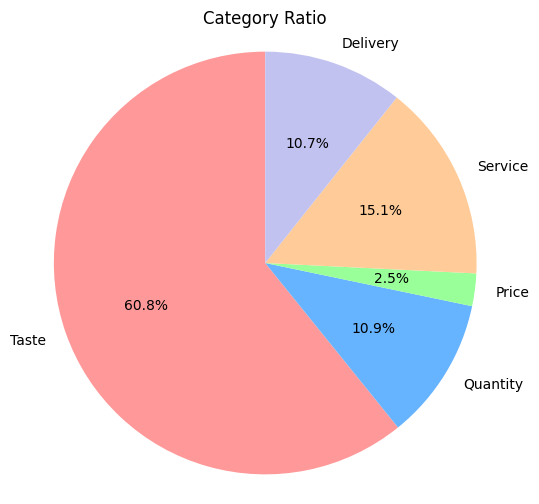

In [155]:
import matplotlib.pyplot as plt

# 주어진 데이터
data = {
    'Taste': 18.243575,
    'Quantity': 3.273765,
    'Price': 0.746477,
    'Service': 4.529523,
    'Delivery': 3.206660
}

# 데이터를 파이차트로 그리기
labels = data.keys()
sizes = data.values()

# 색상 설정

colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0']

# 원형 그래프 그리기
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Category Ratio')
plt.axis('equal')  # 원형 그래프를 원으로 보이도록 설정
plt.show()


In [152]:
# 주어진 값으로부터 비율 계산
total = sum(df_total_score.values())
ratios = {k: v / total for k, v in df_total_score.items()}

# 비율로 변환된 데이터를 데이터프레임으로 만듦
df = pd.DataFrame(ratios, index=[0])

# 히스토그램 그리기
plt.figure(figsize=(8, 4))
df.plot(kind='bar', stacked=True)
plt.title('전체 비율 히스토그램')
plt.xlabel('카테고리')
plt.ylabel('비율')
plt.xticks(rotation=0)
plt.show()

TypeError: ignored

### 2) 시간의 흐름에 따른 추이

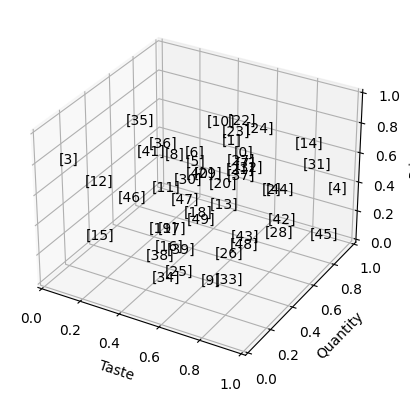

In [144]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 3D 그래프를 그리기 위한 모듈

# 가상의 데이터 생성
np.random.seed(0)
n_samples = 50
variables = ["Taste", "Quantity", "Price", "Service", "Delivery"]
data = np.random.rand(n_samples, len(variables))

# 데이터 포인트 이름 또는 식별자
point_names = [f"Point {i+1}" for i in range(n_samples)]

# 3D 포지셔닝 맵 그리기
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(n_samples):
    x = data[i, 0]  # 맛
    y = data[i, 1]  # 양
    z = data[i, 2]  # 가격
    label = [i]
    ax.text(x, y, z, label)

ax.set_xlabel(variables[0])
ax.set_ylabel(variables[1])
ax.set_zlabel(variables[2])

plt.show()


### 3) 고객 유형화, 군집화
- 재주문, 단골, / 전체 긍부정 지수 등 확인 가능?

In [97]:
!pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.5/189.5 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 87.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 31.5 MB/s eta 0:00:00
  Attempting uninstall: tzlocal
    Found existing installation: tzlocal 5.0.1
    Uninstalling tzlocal-5.0.1:
      Successfully uninstalled tzlocal-5.0.1


In [103]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt

# Streamlit 앱 제목
st.title("간단한 데이터 시각화 예제")

# 데이터 로드

# 데이터 시각화
st.write("데이터 테이블")
st.write(train_ft)

# 히스토그램 생성
st.write("데이터 히스토그램")
plt.hist(train_ft["score"], bins=20)
st.pyplot()

# 대시보드 위젯 추가
st.sidebar.title("대시보드 설정")
selected_column = st.sidebar.selectbox("score", train_ft.columns)
filtered_data = train_ft[train_ft["score"] == selected_column]
st.write("선택한 열의 데이터")
st.write(filtered_data)


In [104]:
# streamlit run your_app.py


SyntaxError: ignored

ValueError: ignored

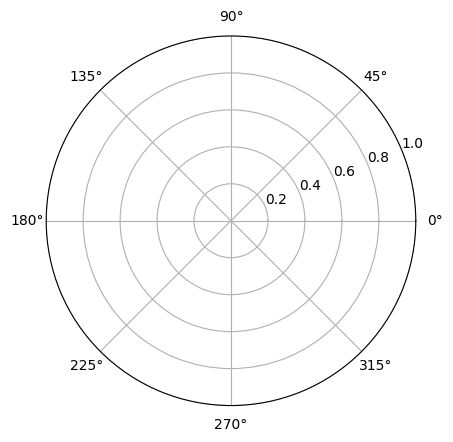

In [93]:
import numpy as np
import matplotlib.pyplot as plt

# 각 카테고리와 점수 데이터 (예시)
categories = ["맛", "양", "배달", "가격", "서비스"]
scores = [0.8, 0.6, 0.7, 0.5, 0.9]  # 각 카테고리의 점수 (0~1 범위)

# 긍정/부정 지수 (예시)
positive_score = 0.8
negative_score = 0.2

# 레이더 차트 그리기
fig, ax = plt.subplots(subplot_kw=dict(polar=True))
theta = np.linspace(0, 2 * np.pi, len(categories), endpoint=False)
scores += scores[:1]  # 첫 번째 데이터를 마지막으로 연결하여 다각형을 완성
theta += np.pi / 2  # 각도를 90도 회전하여 0도가 위쪽으로 향하도록 함

# 레이더 차트 그리기
ax.fill(theta, scores, 'b', alpha=0.1)  # 카테고리별 점수
ax.set_xticks(theta)
ax.set_xticklabels(categories)
ax.set_yticklabels([])
ax.set_title("카테고리별 점수")

# 긍정/부정 지수 표시
plt.figtext(0.15, 0.85, f"긍정 지수: {positive_score:.2f}", color='g', fontsize=12)
plt.figtext(0.15, 0.8, f"부정 지수: {negative_score:.2f}", color='r', fontsize=12)

plt.show()


In [ ]:
positive_reviews = [
    "오늘 배달 시간이 빨라서 좋았어요. 음식도 맛있게 먹었습니다!",
    "음식이 신선하고 양도 푸짐해서 만족스러웠어요.",
    "서비스가 친절하고 음식이 정말 맛있었어요. 다음에도 주문할게요!",
    "배달원 분이 너무 친절하셨어요. 감사합니다!",
    "배달이 빨라서 기분이 좋았습니다. 음식도 예상대로 맛있었어요.",
    "가격 대비 음식의 품질이 좋아서 좋았어요.",
    "주문한 음식이 따뜻하게 도착했고 맛있게 먹었습니다.",
    "매번 여기서 주문하는데 항상 만족스러워요. 최고에요!",
    "음식이 정말 맛있어서 가족 모두가 만족했어요.",
    "주문한 음식이 신선하게 잘 도착했고, 배달원 분이 친절해서 기분 좋았습니다."
]

negative_reviews = [
    "음식이 덜 익어서 먹을 수가 없었어요. 실망했습니다.",
    "배달이 매우 늦어져서 기다리는 동안 짜증났어요.",
    "음식 양도 적고 가격 대비 별로였습니다.",
    "주문한 음식이 차가워서 더 이상 시킬 의향이 없습니다.",
    "배달원 분이 불친절해서 좋지 않은 경험이었습니다.",
    "음식이 짠 맛이 나서 먹을 수가 없었습니다. 돈이 아까웠어요.",
    "음식이 퍼져서 배달 상태가 좋지 않았습니다.",
    "음식 포장이 엉망이었고, 음식 퀄리티도 별로여서 실망스러웠습니다.",
    "음식이 별로였고, 가격도 비싸서 다른 곳에서 시킬게요.",
    "배달이 완전히 틀려서 다시 기다리느라 시간 낭비했습니다."
]

test_reviews = positive_reviews + negative_reviews

In [ ]:
positive_reviews_messed_up = [
    "오늘배달시간이빨라서좋았어요.음식도맛있게먹었습니다!",
    "음식이완전쩔어서양도개많아서만족해짐.",
    "서비스가엄청친절하고음식이진짜맛있었어요.다음에도진짜주문할게요!",
    "배달원분이개쌍판데기친절하셨어요.감사합니다!",
    "배달이엄청빨라서기분이쩐다.음식도완전예상대로맛있었어요.",
    "가격대비음식의퀄리티가미쳤어서좋았어요.",
    "주문한음식이엄청따뜻하게도착했고맛있게먹었어요.",
    "매번여기서주문하는데항상개쩐다.진짜최고에요!",
    "음식이정말미친맛이어서가족모두가개좋아했어요.",
    "주문한음식이엄청신선했고,배달원분이개친절해서개기분좋았습니다."
]

# 서비스 1 - B. 토픽별 긍부정지수 제공

# 서비스 1 - C. 고객 분류 제공 (악성 - 단골)
- Id 확인 + 시간대 분석
- 주문 시간대 확인 가능?
- 어떤 손님인지 고객을 분석할 수는 없나?